# Наивный Байес и спам
__Суммарное количество баллов: 8__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW10] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

In [113]:
import re
import copy
import spacy
import string
import pandas
import random
import matplotlib

import numpy as np
import matplotlib.pyplot as plt

from typing import NoReturn
from collections import Counter
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer

In [4]:
def read_dataset(filename):
    file = open(filename, encoding="utf-8")
    x, y = [], []

    for line in file:
        cl, sms = re.split("^(ham|spam)[\t\s]+(.*)$", line)[1:3]
        x.append(sms)
        y.append(cl)
        
    return np.array(x, dtype=np.str), np.array(y, dtype=np.str)

In [5]:
def get_precision_recall_accuracy(y_pred, y_true):
    classes = np.unique(list(y_pred) + list(y_true))
    true_positive = dict((c, 0) for c in classes)
    true_negative = dict((c, 0) for c in classes)
    false_positive = dict((c, 0) for c in classes)
    false_negative = dict((c, 0) for c in classes)
    for c_pred, c_true in zip(y_pred, y_true):
        for c in classes:
            if c_true == c:
                if c_pred == c_true:
                    true_positive[c] = true_positive.get(c, 0) + 1
                else:
                    false_negative[c] = false_negative.get(c, 0) + 1
            else:
                if c_pred == c:
                    false_positive[c] = false_positive.get(c, 0) + 1
                else:
                    true_negative[c] = true_negative.get(c, 0) + 1
    precision = dict((c, true_positive[c] / (true_positive[c] + false_positive[c])) for c in classes)
    recall = dict((c, true_positive[c] / (true_positive[c] + false_negative[c])) for c in classes)
    accuracy = sum([true_positive[c] for c in classes]) / len(y_pred)
    return precision, recall, accuracy

def plot_precision_recall(X_train, y_train, X_test, y_test, bow_method, voc_sizes=range(4, 200, 5)):
    classes = np.unique(list(y_train) + list(y_test))
    precisions = dict([(c, []) for c in classes])
    recalls = dict([(c, []) for c in classes])
    accuracies = []
    for v in voc_sizes:
        bow = bow_method(X_train, voc_limit=v)
        X_train_transformed = bow.transform(X_train)
        X_test_transformed = bow.transform(X_test)
        classifier = NaiveBayes(0.001)
        classifier.fit(X_train_transformed, y_train)
        y_pred = classifier.predict(X_test_transformed)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in classes:
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("Vocabulary size")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(list(ys.values()))-0.01, np.max(list(ys.values()))+0.01)
        for c in ys.keys():
            plt.plot(x, ys[c], label="Class " + str(c))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(voc_sizes, recalls, "Recall")
    plot(voc_sizes, precisions, "Precision")
    plot(voc_sizes, {"":accuracies}, "Accuracy", legend=False)

In [165]:
X, y = read_dataset("spam")

In [166]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, random_state=42)

### Задание 1 (3 балла)
Реализуйте классификацию методом Байеса в предположении независимости компонент `x`. При реализации следует считать, что значения каждой компоненты дискретны, а `p(x|y)` имеет мультиномиальное распределение.

#### Методы
`fit(X, y)` - оценивает параметры распределения `p(x|y)` для каждого `y`. 

`log_proba(X)` - для каждого элемента набора `X` считает логарифм вероятности отнести его к каждому классу. По теореме Байеса: `p(y|x) = p(y)p(x|y)/p(x)`. Соответственно, после логарифмирования: `log p(y|x) = log p(y) + log p(x|y) - log p(x)`. Поскольку `log p(x)` является независящей от класса `y` константой, это слагаемое никак не влияет на решение задачи максимизации. Поэтому его можно просто убрать для простоты.

In [184]:
class NaiveBayes:
    def __init__(self, alpha: float):
        """
        Parameters
        ----------
        alpha : float
            Параметр аддитивной регуляризации.
        """
        self.alpha = alpha
        self.classes = None
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> "NaiveBayes":
        """
        Оценивает параметры распределения p(x|y) для каждого y.
        """
        self.classes, self.class_count = np.unique(y, return_counts=True)
        self.n_classes = self.classes.shape[0]
        
        self.prob_y = self.class_count / X.shape[0]
        self.prob_xy = np.zeros((self.n_classes, X.shape[1]))
    
        for i, cls in enumerate(self.classes):
            word_in_class_cnt = X[y == cls].sum(axis=0)            
            total_in_class_cnt = word_in_class_cnt.sum()
            
            self.prob_xy[i] = (word_in_class_cnt + self.alpha) / (total_in_class_cnt + self.alpha * X.shape[1])
                    
        return self
    
        
    def predict(self, X: np.ndarray) -> list:
        """
        Return
        ------
        list
            Предсказанный класс для каждого элемента из набора X.
        """
        return [self.classes[i] for i in np.argmax(self.log_proba(X), axis=1)]
    
    def log_proba(self, X: np.ndarray) -> np.ndarray:
        """
        Return
        ------
        np.ndarray
            Для каждого элемента набора X - логарифм вероятности отнести его к каждому классу. 
            Матрица размера (X.shape[0], n_classes)
        """
        log_proba = np.zeros((X.shape[0], self.n_classes))
        
        for i in range(self.n_classes):
            total_prob_cls = np.sum(np.log(self.prob_xy[i]) * X, axis=1) + np.log(self.prob_y[i])
            log_proba[:, i] = total_prob_cls
        
        return log_proba

### Задание 2 (3 балла)
Теперь реализуем метод bag of words. Задача состоит в том, чтобы посчитать количество вхождений каждого слова в предложение.

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [192]:
class BoW:
    def __init__(self, X: np.ndarray, voc_limit: int = 1000):
        """
        Составляет словарь, который будет использоваться для векторизации предложений.

        Parameters
        ----------
        X : np.ndarray
            Массив строк (предложений) размерности (n_sentences, ), 
            по которому будет составляться словарь.
        voc_limit : int
            Максимальное число слов в словаре.

        """
        self.X = X
        self.voc_limit = voc_limit

        words = []
        
        for x in X:
            words += self._tokenize(x)

        unique_words, counts = np.unique(words, return_counts=True)
        top_unique_words = unique_words[np.argpartition(-counts, voc_limit)][:voc_limit]

        self.tokens = {word: i for i, word in enumerate(top_unique_words)}
        
           
    def _tokenize(self, sentence): 
        stopwords = string.punctuation.replace("'", "")
    
        return sentence.strip().lower().translate(str.maketrans('', '', stopwords)).split()

    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Векторизует предложения.

        Parameters
        ----------
        X : np.ndarray
            Массив строк (предложений) размерности (n_sentences, ), 
            который необходимо векторизовать.
        
        Return
        ------
        np.ndarray
            Матрица векторизованных предложений размерности (n_sentences, vocab_size)
        """
        X_bof = np.zeros((X.shape[0], self.voc_limit))
        
        for i, row in enumerate(X):
            for word in self._tokenize(row):
                if word in self.tokens:
                    X_bof[i, self.tokens[word]] += 1
        
        return X_bof

In [198]:
bow = BoW(X_train, voc_limit=500)
X_train_bow = bow.transform(X_train)
X_test_bow = bow.transform(X_test)

In [199]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bow, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bow), y_test)

({'ham': 0.9833679833679834, 'spam': 0.935064935064935},
 {'ham': 0.9895397489539749, 'spam': 0.9},
 0.9767025089605734)

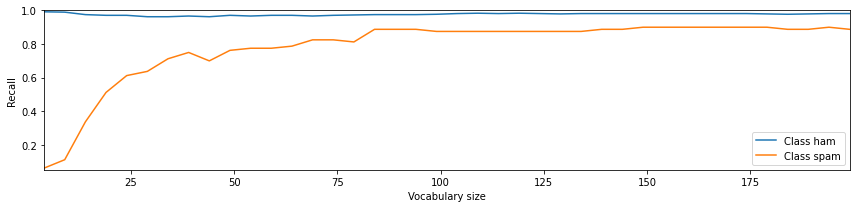

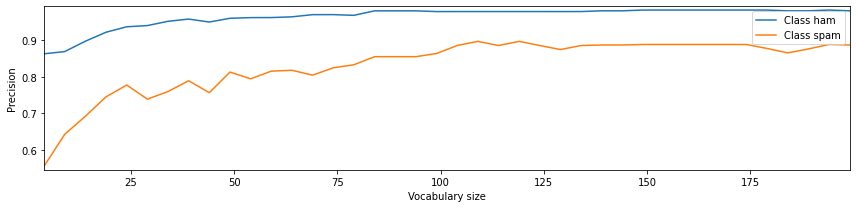

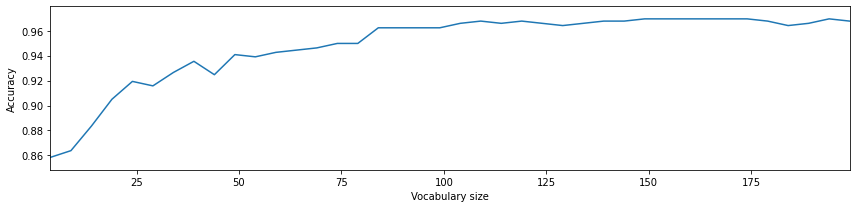

In [195]:
plot_precision_recall(X_train, y_train, X_test, y_test, BoW)

### Задание 3 (2 балла)
Теперь добавим в BoW стемминг. Для этого нам понадобится класс SnowballStemmer из пакета `nltk`

#### Методы
`__init__(X, voc_limit)` - инициализирует BoW, составляя словарь, который будет использоваться для векторизации предложений. Размер словаря должен быть не больше `voc_limit`, в него должны входить самые часто встречающиеся в выборке слова.

`transform(X)` - векторизует сообщения из набора.

In [200]:
class BowStem:
    def __init__(self, X: np.ndarray, voc_limit: int = 1000):
        """
        Составляет словарь, который будет использоваться для векторизации предложений.

        Parameters
        ----------
        X : np.ndarray
            Массив строк (предложений) размерности (n_sentences, ), 
            по которому будет составляться словарь.
        voc_limit : int
            Максимальное число слов в словаре.

        """
        self.X = X
        self.voc_limit = voc_limit

        words = []
        
        for x in X:
            words += self._tokenize(x)

        unique_words, counts = np.unique(words, return_counts=True)
        top_unique_words = unique_words[np.argpartition(-counts, voc_limit)][:voc_limit]

        self.tokens = {word: i for i, word in enumerate(top_unique_words)}
        
        
    def _tokenize(self, sentence): 
        stemmer = SnowballStemmer("english")
        stopwords = string.punctuation.replace("'", "")
    
        words = sentence.strip().lower().translate(str.maketrans('', '', stopwords)).split()
        
        return [stemmer.stem(word) for word in words]
        
    def transform(self, X: np.ndarray) -> np.ndarray:
        """
        Векторизует предложения.

        Parameters
        ----------
        X : np.ndarray
            Массив строк (предложений) размерности (n_sentences, ), 
            который необходимо векторизовать.
        
        Return
        ------
        np.ndarray
            Матрица векторизованных предложений размерности (n_sentences, vocab_size)
        """
        X_bof = np.zeros((X.shape[0], self.voc_limit))
        
        for i, row in enumerate(X):
            for word in self._tokenize(row):
                if word in self.tokens:
                    X_bof[i, self.tokens[word]] += 1
        
        return X_bof

In [201]:
bows = BowStem(X_train, voc_limit=500)
X_train_bows = bows.transform(X_train)
X_test_bows = bows.transform(X_test)

In [202]:
predictor = NaiveBayes(0.001)
predictor.fit(X_train_bows, y_train)
get_precision_recall_accuracy(predictor.predict(X_test_bows), y_test)

({'ham': 0.983402489626556, 'spam': 0.9473684210526315},
 {'ham': 0.9916317991631799, 'spam': 0.9},
 0.978494623655914)

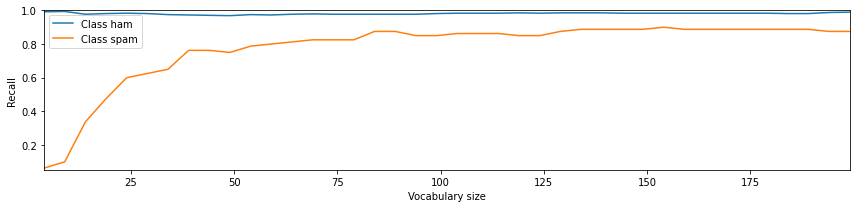

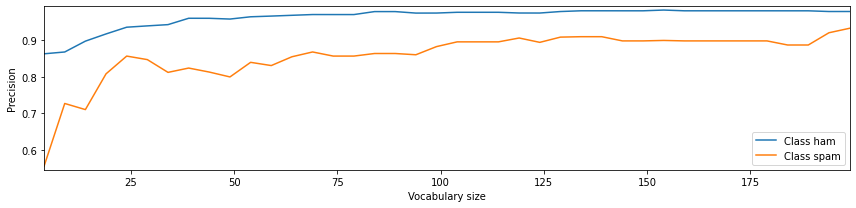

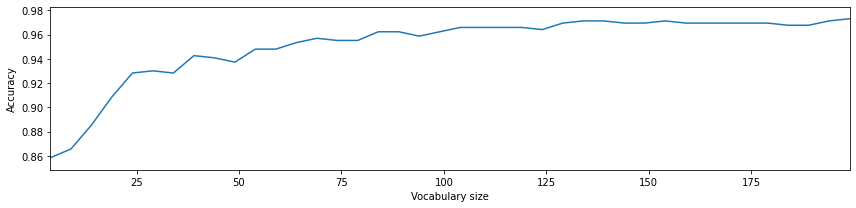

In [203]:
plot_precision_recall(X_train, y_train, X_test, y_test, BowStem)